In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.autograd import Variable
from torch.nn import Conv2d, MaxPool2d, Dropout, Flatten, Linear, ReLU, Softmax, Module, Sequential
from torch.utils.data import TensorDataset, DataLoader

In [3]:
#Loading the train data:

data = []
labels = []
classes = 43
data_path = '../input/gtsrb-german-traffic-sign'
#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(data_path,'train',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)/256
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

#Shape is now (39209, 30, 30, 3) for the data and (39209,) for the labels
#We want it to be (39209, 3, 30, 30) for pytorch conv2d
data = np.moveaxis(data, 3, 1)

In [4]:
#Loading the test data:

y_test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
test_labels = y_test["ClassId"].values

test_data=[]
path = os.path.join(data_path,'Test')
images = sorted(os.listdir(path))
for a in images:
    try:
        image = Image.open(path + '/'+ a)
        image = image.resize((30,30))
        image = np.array(image)
        test_data.append(image)
    except:
        print("Error loading image")


test_data = np.array(test_data)
test_data = np.moveaxis(test_data, 3, 1)



Error loading image


In [5]:
#Creating a validation set and converting the data to Tensors

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train).to("cuda")
X_val = torch.Tensor(X_val).to("cuda")
y_train = torch.Tensor(y_train).type(torch.LongTensor).to("cuda")
y_val = torch.Tensor(y_val).type(torch.LongTensor).to("cuda")


In [129]:
#Hyperparameters 

BATCH_SIZE = 32
LEARNING_RATE =0.001
n_epochs = 20

In [130]:
#Create DataLoaders

TrainDataSet = TensorDataset(X_train,y_train)
ValDataSet = TensorDataset(X_val,y_val)

train_dl = DataLoader(TrainDataSet, BATCH_SIZE)
val_dl = DataLoader(ValDataSet, BATCH_SIZE)



In [131]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.cnn_layers = Sequential(
            Conv2d(3,32,kernel_size=5),
            #26*26*32
            ReLU(inplace=True),
            Conv2d(32,32,kernel_size=5),
            #22*22*32
            ReLU(inplace=True),
            MaxPool2d(2),
            #11*11*32
            Dropout(0.25),
            Conv2d(32,64,kernel_size=3),
            #9*9*64
            ReLU(inplace=True),
            Conv2d(64,64,kernel_size=3),
            #7*7*64
            ReLU(inplace=True),
            MaxPool2d(2),
            #3*3*64
            Dropout(0.25),
            Flatten(),
            #576
        )
        
        self.linear_layers = Sequential(
            Linear(3*3*64,256),
            ReLU(inplace=True),
            Dropout(0.5),
            Linear(256,43),


        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

In [132]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam,SGD

model = Net()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion =  criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=43, bias=True)
  )
)


In [133]:
def train(epoch):
    
    model.train()
    tr_loss = 0
    val_loss = 0
    
    for x_train, y_train in train_dl:

     
        # prediction for the training set
        output_train = model(x_train)
        

        # computing the training loss
        loss_train = criterion(output_train, y_train)

        train_losses.append(loss_train.item())

        # computing the updated weights of all the model parameters
        tr_loss += loss_train.item()
        
        loss_train.backward()

        optimizer.step()
         
        optimizer.zero_grad()
        
        
    model.eval()
    
    for x_val, y_val in  val_dl:
        with torch.no_grad():

            # clearing the Gradients of the model parameters
            optimizer.zero_grad()
    
            # prediction for the validation set
            output_val = model(x_val)

            # computing the validation loss
            loss_val = criterion(output_val, y_val)
            val_losses.append(loss_val.item())

            val_loss += loss_val.item()
        


    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', val_loss)

    

In [134]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : 90.24760717153549
Epoch :  3 	 loss : 28.750929141184315
Epoch :  5 	 loss : 11.910688912103069
Epoch :  7 	 loss : 11.003567641237169
Epoch :  9 	 loss : 9.341111971389182
Epoch :  11 	 loss : 7.788378819892387
Epoch :  13 	 loss : 14.057617573134848
Epoch :  15 	 loss : 9.593069316222682
Epoch :  17 	 loss : 6.4437331226496894
Epoch :  19 	 loss : 8.800311462617714


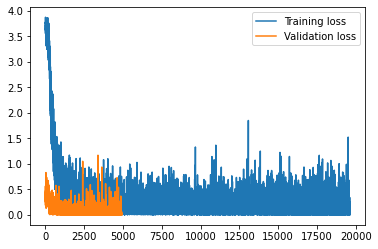

In [135]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [136]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    output = model(X_train)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
train_acc = accuracy_score(y_train.cpu().numpy(), predictions)

with torch.no_grad():
    output = model(X_val)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
val_acc = accuracy_score(y_val.cpu().numpy(), predictions)

In [137]:
print("Train accuracy: {}".format(train_acc))
print("Validation accuracy: {}".format(val_acc))

Train accuracy: 0.9967481748334237
Validation accuracy: 0.993241520020403


In [138]:
with torch.no_grad():
    output = model(torch.Tensor(test_data).cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

test_acc = accuracy_score(test_labels, predictions)

In [139]:
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.8852731591448931


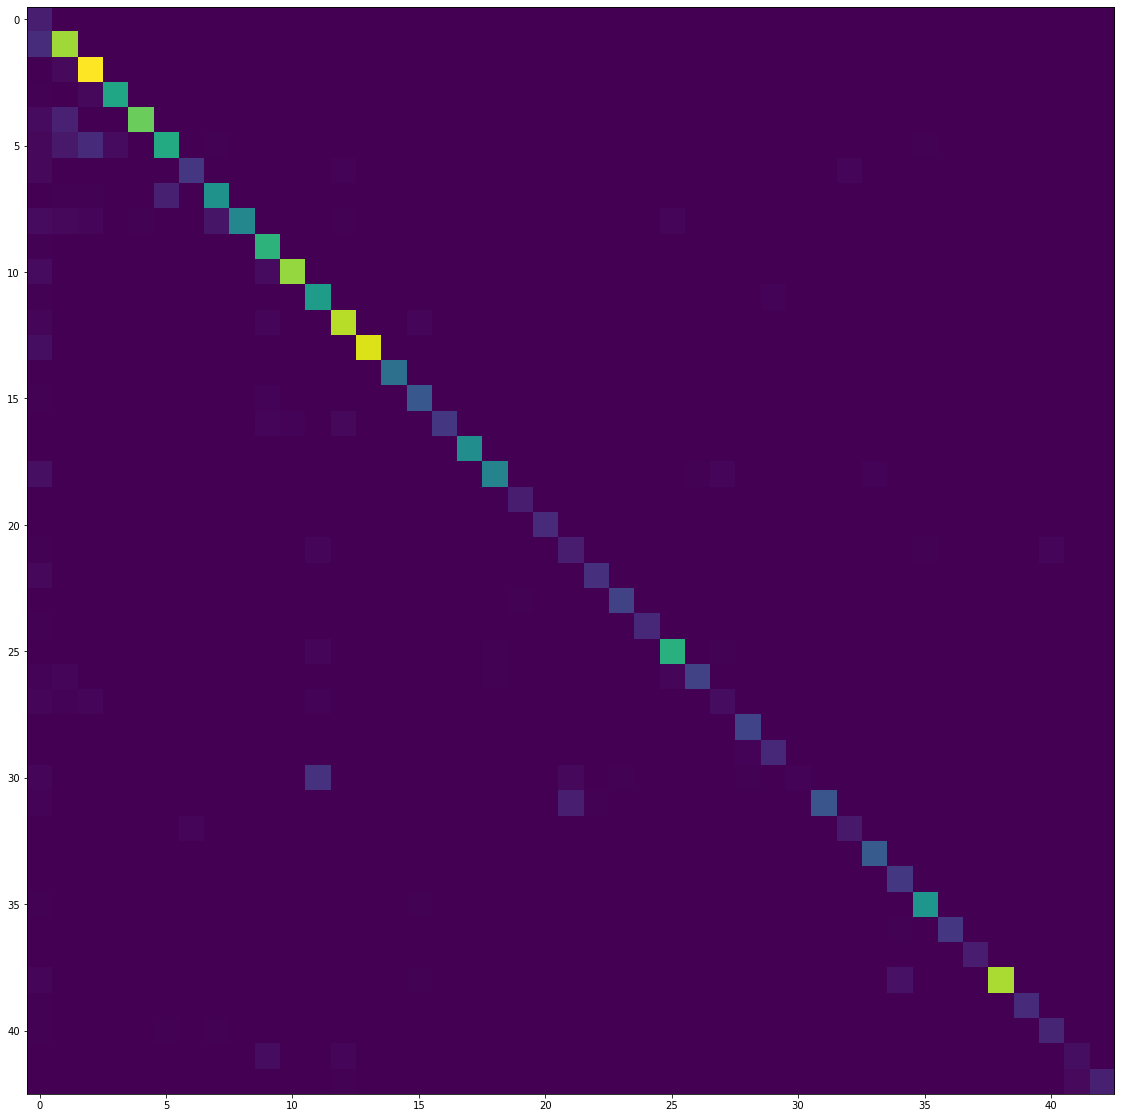

In [140]:
#Stop sign = 14

conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize = (20,20))
plt.imshow(conf_matrix)


In [141]:
conf_matrix[14]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 268,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])